# WORLD HAPPINESS REPORT - MACHINE LEARNING - CLUSTERING

## This script includes following:
1. Import libraries and data
2. Data preparation
3. The elbow technique
4. K-means clustering (visualizations and descriptive statistics)
5. Export data

### 1. Import libraries and data

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import OneHotEncoder # Added when I received a value error for Switzerland. 
from sklearn.preprocessing import LabelEncoder # Added when I received a value error for Switzerland. 
from sklearn.compose import ColumnTransformer # Added when I received a value error for Switzerland. 
from sklearn.cluster import KMeans # Import the k-means algorithm from scikit-learn.
from sklearn.pipeline import Pipeline # Added when I received a value error for Switzerland
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

# Country Switzerland was not numerical in the dataframe, but a string. The added libraries were needed to fix this problem.

In [158]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [159]:
# define path
path = r'C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\02 Data'

In [160]:
# import df world happiness report. I call it whr to have a short name.
whr = pd.read_pickle(os.path.join(path,'whr1.pkl'))

### 2. Data preparation

In [162]:
whr.columns # list columns in the dataframe whr

Index(['Generosity', 'Year', 'Overall rank', 'Country or region',
       'Freedom to make life choices', 'Life expectancy', 'Happiness (Score)',
       'Trust (Gov.corruption)', 'Economy (GDP p. cap.)', 'Family support'],
      dtype='object')

In [163]:
whr.shape # check the nr of columns and rows in the file

(782, 10)

In [164]:
whr.head(3) # look at the columns 

,Generosity,Year,Overall rank,Country or region,Freedom to make life choices,Life expectancy,Happiness (Score),Trust (Gov.corruption),Economy (GDP p. cap.),Family support
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223
2,0.34139,2015,3.0,Denmark,0.64938,0.87464,7.527,0.48357,1.32548,1.36058


In [165]:
# Rename the columns 

whr.rename(columns = {'Happiness (Score)' : 'Happiness Score', 'Country or region': 'Country', 'Freedom to make life choices': 'Freedom', 'Trust (Gov.corruption)': 'Trust', 'Economy (GDP p. cap.)': 'GDP per capita' }, inplace = True)

In [166]:
whr.head(3) # Check after renaming

,Generosity,Year,Overall rank,Country,Freedom,Life expectancy,Happiness Score,Trust,GDP per capita,Family support
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223
2,0.34139,2015,3.0,Denmark,0.64938,0.87464,7.527,0.48357,1.32548,1.36058


In [167]:
# Identify categorical and numeric columns
categorical_cols = whr.select_dtypes(include=["object"]).columns
numeric_cols = whr.select_dtypes(include=["int64", "float64"]).columns


In [168]:
# Preprocess: one-hot encode categoricals, keep numeric as is
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [169]:
# It was necessary to clean the file from NaN values in order to perform the clustering, otherwise error. KMeans does not accept NaN values. 
# Drop all rows with NaN values
whr_clean = whr.dropna()

# Save the cleaned file (optional)
whr_clean.to_pickle("whr_clean.pkl")

In [170]:
print(os.getcwd()) # Find the file. I move it manually to the data folder. Why does it end up in the wrong place?

C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\03 Scripts


In [171]:
# import whr_clean and continue with dropped NaN values.
whr1 = pd.read_pickle(os.path.join(path,'whr_clean.pkl'))

In [172]:
whr1.head(3) # Check if renaming was saved

,Generosity,Year,Overall rank,Country or region,Freedom to make life choices,Life expectancy,Happiness (Score),Trust (Gov.corruption),Economy (GDP p. cap.),Family support
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223
2,0.34139,2015,3.0,Denmark,0.64938,0.87464,7.527,0.48357,1.32548,1.36058


In [173]:
# Rename the columns again

whr1.rename(columns = {'Happiness (Score)' : 'Happiness Score', 'Country or region': 'Country', 'Freedom to make life choices': 'Freedom', 'Trust (Gov.corruption)': 'Trust', 'Economy (GDP p. cap.)': 'GDP per capita' }, inplace = True)

In [174]:
whr1.head(3) # Renamed columns? Yes.

,Generosity,Year,Overall rank,Country,Freedom,Life expectancy,Happiness Score,Trust,GDP per capita,Family support
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223
2,0.34139,2015,3.0,Denmark,0.64938,0.87464,7.527,0.48357,1.32548,1.36058


In [175]:
whr1.isna().sum().sum() # Count if NaN values are present

0

In [176]:
print(whr1.columns)

Index(['Generosity', 'Year', 'Overall rank', 'Country', 'Freedom',
       'Life expectancy', 'Happiness Score', 'Trust', 'GDP per capita',
       'Family support'],
      dtype='object')


### 3. The elbow technique

In [193]:
# Drop the Country column since KMean does not work on non numeric columns 
whr2 = whr1.drop(columns=['Country'])

In [195]:
print(whr2.columns)

Index(['Generosity', 'Year', 'Overall rank', 'Freedom', 'Life expectancy',
       'Happiness Score', 'Trust', 'GDP per capita', 'Family support',
       'Country_numeric'],
      dtype='object')


In [200]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [201]:
score = [kmeans[i].fit(whr2).score(whr2) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.
score

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

[-2048979.3129851748,
 -1234855.4638625681,
 -792723.8896455988,
 -517311.1128244996,
 -402679.0499990001,
 -352156.6123571353,
 -290853.71078953677,
 -250728.8999093864,
 -218459.5491287952]

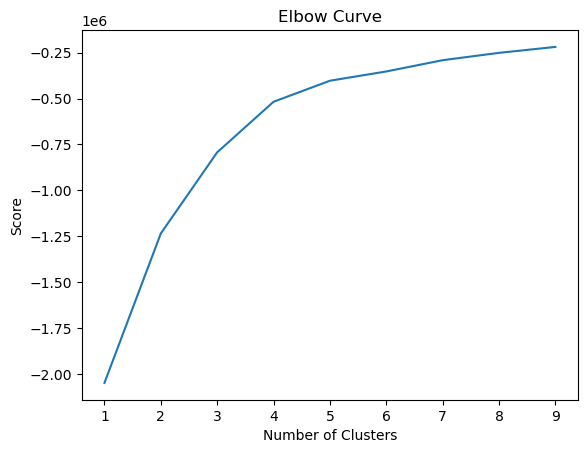

In [202]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [203]:
# There is a large jump between 1 and 5 on the elbow curve, which means that 5 clusters is the right amount of clusters to use in this case.

### 4. K-MEANS CLUSTERING

In [205]:
# Create the k-means object.

kmeans = KMeans(n_clusters = 5) 


In [206]:
# Fit the k-means object to the data.

kmeans.fit(whr2)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=5)

In [207]:
whr2['clusters'] = kmeans.fit_predict(whr2) # What cluster should the data be assigned to?

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [210]:
whr2.head(3) # Show columns

,Generosity,Year,Overall rank,Freedom,Life expectancy,Happiness Score,Trust,GDP per capita,Family support,Country_numeric,clusters
0,0.29678,2015,1.0,0.66557,0.94143,7.587,0.41978,1.39651,1.34951,142,0
1,0.43630,2015,2.0,0.62877,0.94784,7.561,0.14145,1.30232,1.40223,60,4
2,0.34139,2015,3.0,0.64938,0.87464,7.527,0.48357,1.32548,1.36058,38,4


In [211]:
whr2['clusters'].value_counts() # Are all clusters represented in the data? Count how many assigments to each cluster.

clusters
0    108
1     99
3     95
2     93
4     75
Name: count, dtype: int64

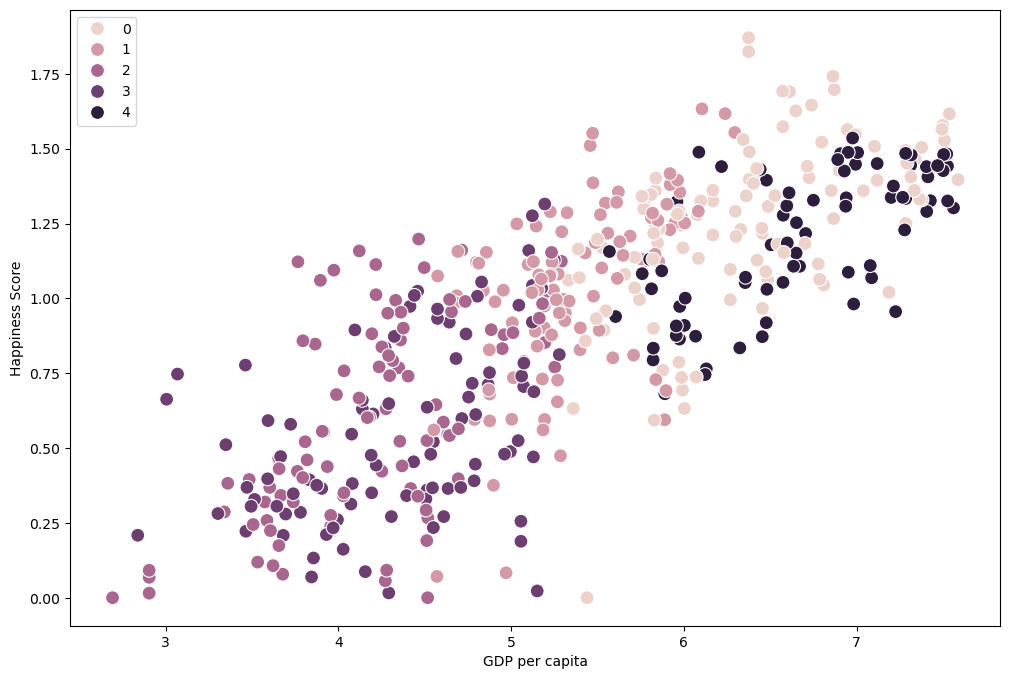

In [212]:
# Plot the clusters for the "Happiness Score" and "GDP per capita" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=whr2['Happiness Score'], y=whr2['GDP per capita'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('GDP per capita') # Label x-axis.
plt.ylabel('Happiness Score') # Label y-axis.
plt.show()

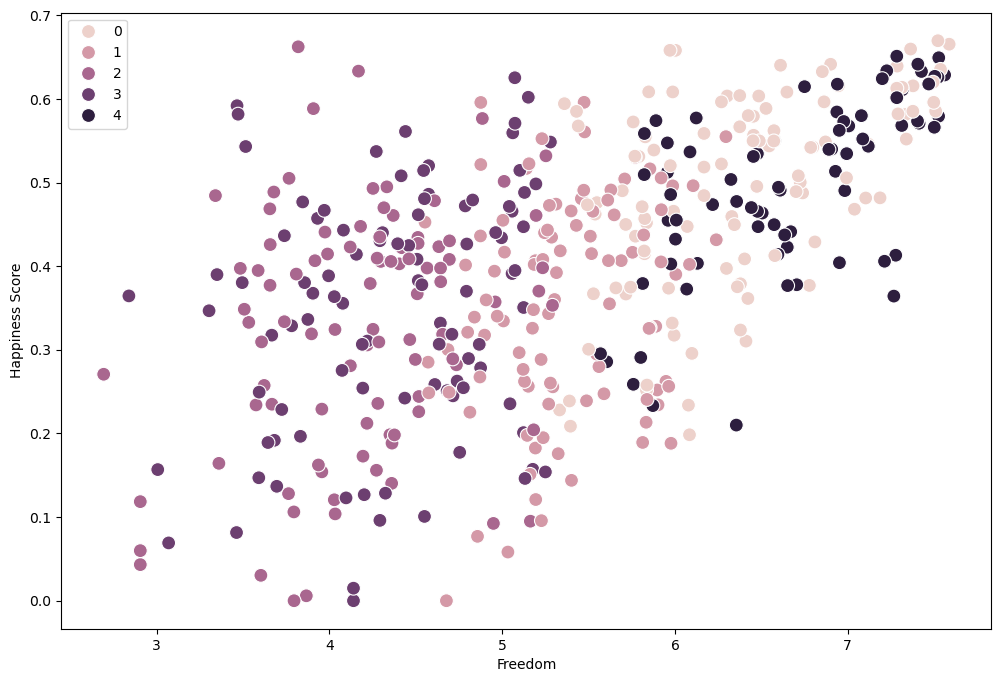

In [213]:
# Plot the clusters for the "Happiness Score" and "Freedom" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=whr2['Happiness Score'], y=whr2['Freedom'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Freedom') # Label x-axis.
plt.ylabel('Happiness Score') # Label y-axis.
plt.show()

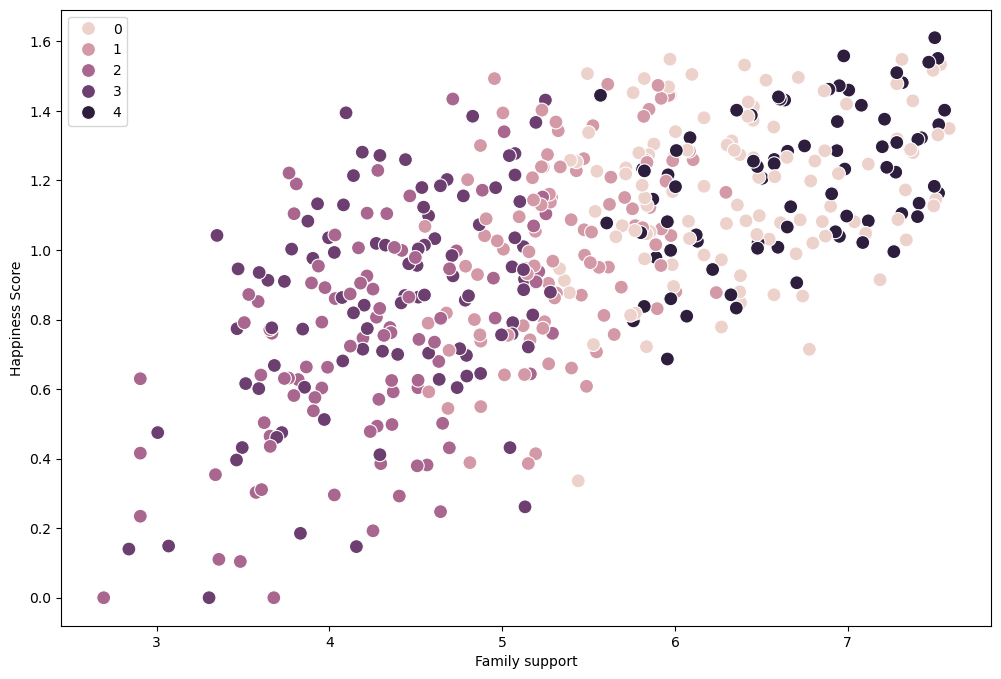

In [214]:
# Plot the clusters for the "Happiness Score" and "Family support" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=whr2['Happiness Score'], y=whr2['Family support'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Family support') # Label x-axis.
plt.ylabel('Happiness Score') # Label y-axis.
plt.show()

In [217]:
# A high level of family support also has a positive effect on happiness. 

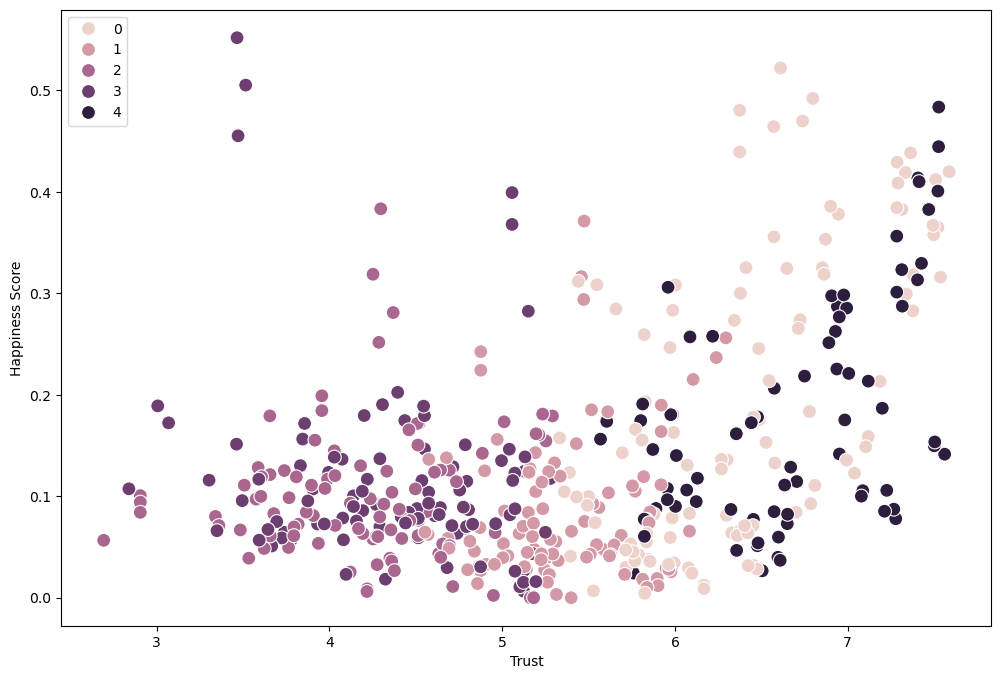

In [215]:
# Plot the clusters for the "Happiness Score" and "Trust" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=whr2['Happiness Score'], y=whr2['Trust'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Trust') # Label x-axis.
plt.ylabel('Happiness Score') # Label y-axis.
plt.show()

In [216]:
# Where there is a high level of trust in government institutions, people tend to be happier. Looking at all graphs it seems like trust is important for happiness. There are exceptions. 

In [219]:
whr2.loc[whr2['clusters'] == 4, 'cluster'] = 'black' # Assign a color column to the clusters
whr2.loc[whr2['clusters'] == 3, 'cluster'] = 'dark purple'
whr2.loc[whr2['clusters'] == 2, 'cluster'] = 'purple'
whr2.loc[whr2['clusters'] == 1, 'cluster'] = 'light purple'
whr2.loc[whr2['clusters'] == 0, 'cluster'] = 'pink'

In [241]:
whr2.groupby('cluster').agg({'Freedom':['mean', 'median'], 
                         'Life expectancy':['mean', 'median'], 
                         'Happiness Score':['mean', 'median'],
                          'Trust':['mean', 'median'], # Group into the color cluster and calculate mean and median for each of the variables.
                          'GDP per capita':['mean', 'median'],
                            'Generosity':['mean', 'median'], 
                              'Overall rank':['mean', 'median'], 
                                'Year':['mean', 'median'],
                          'Family support':['mean', 'median']})

Freedom           Life expectancy           Happiness Score  \
                  mean    median            mean    median            mean   
cluster                                                                      
black         0.498779  0.513540        0.749262  0.792566        6.675947   
dark purple   0.347888  0.367720        0.394581  0.364509        4.364389   
light purple  0.354792  0.360230        0.651708  0.641022        5.365889   
pink          0.494837  0.521341        0.740426  0.754760        6.375741   
purple        0.325854  0.353270        0.370108  0.345780        4.184151   

                        Trust           GDP per capita           Generosity  \
             median      mean    median           mean    median       mean   
cluster                                                                       
black         6.652  0.181506  0.156314       1.200663  1.252785   0.243504   
dark purple   4.440  0.116074  0.089848       0.559157  0.488350   0.250184   
light purple  5.293  0.086718  0.063320       1.031043  1.074988   0.226584   
pink          6.375  0.192421  0.150873       1.248598  1.280754   0.270766   
purple        4.252  0.100480  0.087220       0.602028  0.564305   0.216650   

                       Overall rank                Year          \
                median         mean median         mean  median   
cluster                                                           
black         0.231503    27.013333   24.0  2016.000000  2016.0   
dark purple   0.216740   120.715789  120.0  2016.021053  2016.0   
light purple  0.212300    77.717172   78.0  2015.969697  2016.0   
pink          0.256165    37.324074   35.5  2015.990741  2016.0   
purple        0.204435   127.215054  128.0  2015.989247  2016.0   

             Family support            
                       mean    median  
cluster                                
black              1.198759  1.223930  
dark purple        0.856583  0.878770  
light purple       1.013632  1.041030  
pink               1.172294  1.184922  
purple             0.722831  0.754373

In [246]:
# If I compare the Overall rank with the mean and medians in different clusters I see following:
# The cluster with countries with the lowest ranking (=best results), have a high level of freedom, high life expectancy, high happiness score, higher level of trust in government and a high level of family support. 
# All these factors seem to have influence on the overall happiness. The only thing that does not seem to influence happiness significantly is the Generosity. 

### 5. EXPORT DATA

In [248]:
# Add cluster labels back into the original DataFrame
whr1['Cluster'] = kmeans.labels_

# Now you have both Country + Cluster
print(whr1[['Country', 'Cluster']].head())

       Country  Cluster
0  Switzerland        0
1      Iceland        4
2      Denmark        4
3       Norway        0
4       Canada        4


In [249]:
whr1.head(2)

,Generosity,Year,Overall rank,Country,Freedom,Life expectancy,Happiness Score,Trust,GDP per capita,Family support,Country_numeric,Cluster
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951,142,0
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223,60,4


In [250]:
# Save DataFrame 'whr3' to CSV
whr1.to_csv(r'C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\02 Data\whr3.csv', index=False)